# Basic Conditional VAE

**Author:** Maxime Robeyns (2021) <maximerobeyns@gmail.com>

In this file, we train a CVAE on MNIST data. We use $y \in [0, 1]^{784}$ to denote the flattened pixel data, and $x \in \{0, 1\}^{10}$ to denote one-hot encoded MNIST image labels.

The latent variable model is $p(y, z | x)$, where the encoder finds $\hat{z} \sim q(z | y, x)$, and the decoder is $\hat{y} \sim p(y | z, x)$. Following [Sohn et al., 2015](https://proceedings.neurips.cc/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf), the recognition network is the same as the prior network $q(z | x, y) = p(z | x)$

In [1]:
import os
import torch as t
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
try: # One-time setup
    assert(_SETUP)
except NameError:
    while not '.git' in os.listdir():
        os.chdir("../")
    device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
    if device == t.device("cuda"):
        !nvidia-smi
    else:
        print('CUDA is unavailable; training on CPU.')
    _SETUP = True

## Utility functions

In [4]:
def load_mnist(batch_size: int = 64) -> tuple[DataLoader, DataLoader]:
    """(Down)load MNIST dataset in ./data/testdata, and return training and
    test DataLoaders using specified batch_size.
    """

    cuda_kwargs = {'num_workers': 1} #, 'pin_memory': True}
    train_kwargs = {'batch_size': batch_size, 'shuffle': True} | cuda_kwargs
    test_kwargs = {'batch_size': batch_size, 'shuffle': False} | cuda_kwargs

    transform = transforms.Compose([transforms.ToTensor()])

    train_set = datasets.MNIST('./data/testdata', train=True, download=True, 
                               transform=transform)
    test_set = datasets.MNIST('./data/testdata', train=False, download=True, 
                              transform=transform)

    train_loader = DataLoader(train_set, **train_kwargs)
    test_loader = DataLoader(test_set, **test_kwargs)

    return train_loader, test_loader

def onehot(idx: t.Tensor, n: int) -> t.Tensor:
    """Turns an index into a one-hot encoded vector, of length n"""
    assert t.max(idx).item() < n
    
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = t.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    
    return onehot

In [9]:
class VAE(nn.Module):
    """Variational AutoEncoder"""
    
    def __init__(self, encoder_layers: list[int], latent_size: int,
                 decoder_layers: list[int], num_labels: int = 0):
        super().__init__()
        assert num_labels > 0
        self.latent_size = latent_size
        self.encoder = Encoder(encoder_layers, latent_size, num_labels)
        self.decoder = Decoder(decoder_layers, latent_size, num_labels)
        
    def forward(self, y: t.Tensor, x: t.Tensor) -> tuple[
        t.Tensor, t.Tensor, t.Tensor, t.Tensor]:
        if y.dim() > 2:
            y = y.view(-1, 28*28)
        
        # parameters for Gaussian latent distribution
        means, log_var = self.encoder(y, x)
        # reparametrised sampling of z
        z = self.reparametrise(means, log_var)
        # reconstruct input image (y), with binary pixel data in [0, 1].
        recon_img = self.decoder(z, x)
        
        return recon_img, means, log_var, z
    
    def reparametrise(self, mu: t.Tensor, log_var: t.Tensor) -> t.Tensor:
        std = t.exp(0.5 * log_var)
        eps = t.randn_like(std)
        return mu + eps * std
    
    def inference(self, z: t.Tensor, x: t.Tensor) -> t.Tensor:
        recon_img = self.decoder(z, x)
        return recon_img

In [11]:
class Encoder(nn.Module):
    def __init__(self, layer_sizes: list[int], latent_size: int,
                 num_labels: int):
        super().__init__()
        
        # input layer is flattened image + one-hot encoded label y in [0, 9]
        layer_sizes[0] += num_labels
        
        self.MLP = nn.Sequential()
        for i, (j, k) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.MLP.add_module(name=f'L{i}', module=nn.Linear(j, k))
            self.MLP.add_module(name=f'A{i}', module=nn.ReLU())
        
        # no output activation function needed for latent distribution params
        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)
        
    def forward(self, y: t.Tensor, x: t.Tensor) -> tuple[t.Tensor, t.Tensor]:
        # The notation of using x to denote inputs, and y to denote outputs is
        # slightly unusual and 'backward' during the encoding step.
        
        x = onehot(x, n=10)
        y = t.cat((y, x), -1)
        
        y = self.MLP(y)
        means = self.linear_means(y)
        log_vars = self.linear_log_var(y)
        
        return means, log_vars

In [12]:
class Decoder(nn.Module):
    def __init__(self, layer_sizes: list[int], latent_size: int,
                 num_labels: int):
        super().__init__()
        
        self.MLP = nn.Sequential()
        input_size = latent_size + num_labels
        
        for i, (j, k) in enumerate(
            zip([input_size]+layer_sizes[:-1], layer_sizes)):
            self.MLP.add_module(name=f'L{i}', module=nn.Linear(j, k))
            if i + 1 < len(layer_sizes):
                self.MLP.add_module(name=f'A{i}', module=nn.ReLU())
            else:
                # sigmoid activation at output since pixels must be in [0, 1]
                self.MLP.add_module(name='sigmoid', module=nn.Sigmoid())
                
    def forward(self, z: t.Tensor, x: t.Tensor) -> t.Tensor:
        x = onehot(x, n=10)
        z = t.cat((z, x), -1)
        
        y = self.MLP(z)
        
        return y

## VAE Loss Function

The loss function comes from the variational lower bound; that is,
\begin{align*}
    \mathcal{L}_{\text{CVAE}}(\theta, \phi; x, y) &= 
    \mathbb{E}_{q_{\phi}(z \vert y, x)}\left[\log p_{\theta}(y \vert z, x)\right]
     - D_{\text{KL}}\left[q_{\phi}(z \vert y, x) \Vert p_{\theta}(z \vert x)\right] \\
       &= \mathbb{E}_{q_{\phi}(z \vert y, x)}\big[\log p_{\theta}(y \vert z, x) + \log p_{\theta}(z \vert x) - \log q_{\phi}(z \vert y, x)\big] \\
       &\doteq \mathbb{E}\big[\mathcal{L}_{\text{logpy}} +
       \mathcal{L}_{\text{logpz}} - \mathcal{L}_{\text{logqz}} \big],
\end{align*}
where the above consists of a reconstruction loss component ($\mathbb{E}_{q_{\phi}(z \vert y, x)}\big[\log p_{\theta}(y \vert z, x)\big] = p_{\theta}(y \vert x)$) which simply consists of the likelihood of the data under our model, as well as a KL divergence term. 

For the (log) likelihood, we are free to choose the most appropriate one for the data we are modelling; in this MNIST example, we will maximise a (factorised) Bernoulli likelihood (since $x \in [0, 1]^{784}$), and this corresponds to minimising a binary cross entropy loss:
$$
\tilde{\mathcal{L}}_{\text{logpy}} = \sum_{i=1}^{784}\hat{y}_{i}\log y_{i} + (1-\hat{y}_{i})\log (1-y_{i}),\hspace{0.5cm}\text{where } \hat{y} = p_{\theta}(y \vert z, x)
$$
For the other terms in the KL divergence, we use the result of the change of variables formula, along with the log determinant of the Jacobian to come to
\begin{align*}
\tilde{\mathcal{L}}_{\text{logpz}} &= - \sum_{i}\frac{1}{2}(x_{i}^2 + \log(2\pi) \\
\tilde{\mathcal{L}}_{\text{logqz}} &= - \sum_{i}\frac{1}{2}\big(\epsilon_{i}^2 + \log (2\pi)\big) + \log \sigma_{i}
\end{align*}

In [20]:
def vae_loss(recon_img: t.Tensor, img: t.Tensor, mean: t.Tensor,
             log_var: t.Tensor) -> t.Tensor:
    """
    Args:
        recon_x, x: Size([mini_batch, 1, 28, 28])
        mean, log_var: Size([mini_batch, latent_size])
    """
    BCE = t.nn.functional.binary_cross_entropy(
        recon_img.view(-1, 28*28), img.view(-1, 28*28), reduction='sum')
    # analytic KL between N(mean, log_var) & N(0,1)
    DKL = -0.5 * t.sum(1 + log_var - mean.pow(2) - log_var.exp())
    
    return (BCE + DKL) / img.size(0)  # average over mini-batch size

In [21]:
def train(train_loader: DataLoader, vae: VAE, opt: t.optim.Optimizer, 
          epochs: int = 2,latent_size: int = 2, log_every: int = 500):
    for e in range(epochs):
        for iteration, (y, x) in enumerate(train_loader):
            
            y, x = y.to(device), x.to(device)
            recon_img, mean, log_var, z = vae(y, x)

            loss = vae_loss(recon_img, y, mean, log_var)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if iteration % log_every == 0 or iteration == len(train_loader)-1:
                print("Epoch: {:02d}/{:02d}, Batch: {:03d}/{:d}, Loss {:9.4f}".format(
                    e, epochs, iteration, len(train_loader)-1, loss.item()))

In [22]:
train_loader, test_loader = load_mnist()
vae = VAE(encoder_layers=[784, 256],
          latent_size=2,
          decoder_layers=[256, 784],
          num_labels=10).to(device)
opt = t.optim.Adam(vae.parameters(), lr=1e-3)
train(train_loader, vae, opt)

Epoch: 00/02, Batch: 000/937, Loss  544.5187
Epoch: 00/02, Batch: 500/937, Loss  154.1646
Epoch: 00/02, Batch: 937/937, Loss  152.1063
Epoch: 01/02, Batch: 000/937, Loss  139.3711
Epoch: 01/02, Batch: 500/937, Loss  141.6258
Epoch: 01/02, Batch: 937/937, Loss  122.6247


In [29]:
def generate(vae: VAE):
    x = t.arange(0, 10).long().unsqueeze(1).to(device)
    z = t.randn([x.size(0), vae.latent_size]).to(device)
    # calls the decoder
    y = vae.inference(z, x)
    plt.figure()
    plt.figure(figsize=(10, 5))
    for p in range(10):
        plt.subplot(2, 5, p+1)
        plt.text(0, 0, f'c={x[p].item():d}', color='black',
                 backgroundcolor='white', fontsize=8)
        plt.imshow(y[p].view(28, 28).cpu().data.numpy())
        plt.axis('off')
    plt.show()

<Figure size 432x288 with 0 Axes>

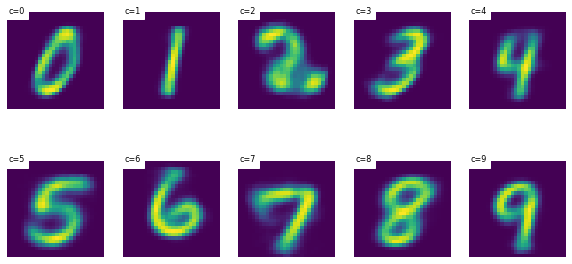

In [42]:
generate(vae)